Для инвестирования 5 млн руб. и cтавки купона, равного 20% разработайте внебиржевой опцион “Autocallable” с ежеквартальным купоном и возможностью досрочного автоматического погашения опциона каждые 3 месяца, если на ежеквартальную купонную дату текущая цена бумаги с наибольшим снижением относительно своей первоначальной стоимости (worst-of performance) превышает или равна барьеру отзыва.

Если продукт не был отозван досрочно, и на последнюю купонную дату текущая цена worst of превышает или равна барьеру поставки, то продукт погашается с выплатой 100% номинала. Иначе, если хотя бы один базовый актив опциона оказался ниже барьера поставки, то осуществляется выплата денежных средств в сумме, равной эквиваленту «поставки бумаги», бумаги с наибольшим снижением относительно своей первоначальной стоимости, по ее первоначальной цене.

В корзину включить четыре базовых актива, первоначальную стоимость определить на день, предшествующий дате запуска (100%). Установить барьер отзыва 105%, купонный барьер 98%, барьер поставки 90% в процентах от первоначальной стоимости каждого базового актива корзину.

**Дата запуска:** 27-07-2022.

**Дата погашения:** 25-07-2023.

**Даты ежеквартальных наблюдений:** 25-10-2022, 25-01-2023, 25-04-2023.

1. Определить действия на купонные даты (выплачивается купон; выплачивается купон с досрочным погашением продукта; не выплачивается, но запоминается; выплачивается купон за текущий и предыдущие кварталы; производится погашение продукта с «эффектом поставки»).
1. Вычислить финансовый результат по состоянию на 25-04-2023,
определить бумагу с наибольшим снижением относительно своей первоначальной стоимости.
1. Привести иллюстративные графики, на которых отобразить бумагу с наибольшим снижением относительно своей первоначальной стоимости (worst-of performance), купонные даты и действия в эти даты, уровни барьеров отзыва, поставки и купонного барьера, первоначальную стоимость актива,
провести исследование влияния уровней барьеров (барьер отзыва, купонный барьер, барьер поставки) на финансовый результат.
1. Повторить расчеты для метода оценки базовых активов -- средневзвешенная динамика стоимости всех активов (average-of perfomance).

[Примеры графиков и расчетов.](https://www.open-broker.com/files/Presentation_OTC-Option_Autocallable_.pdf)


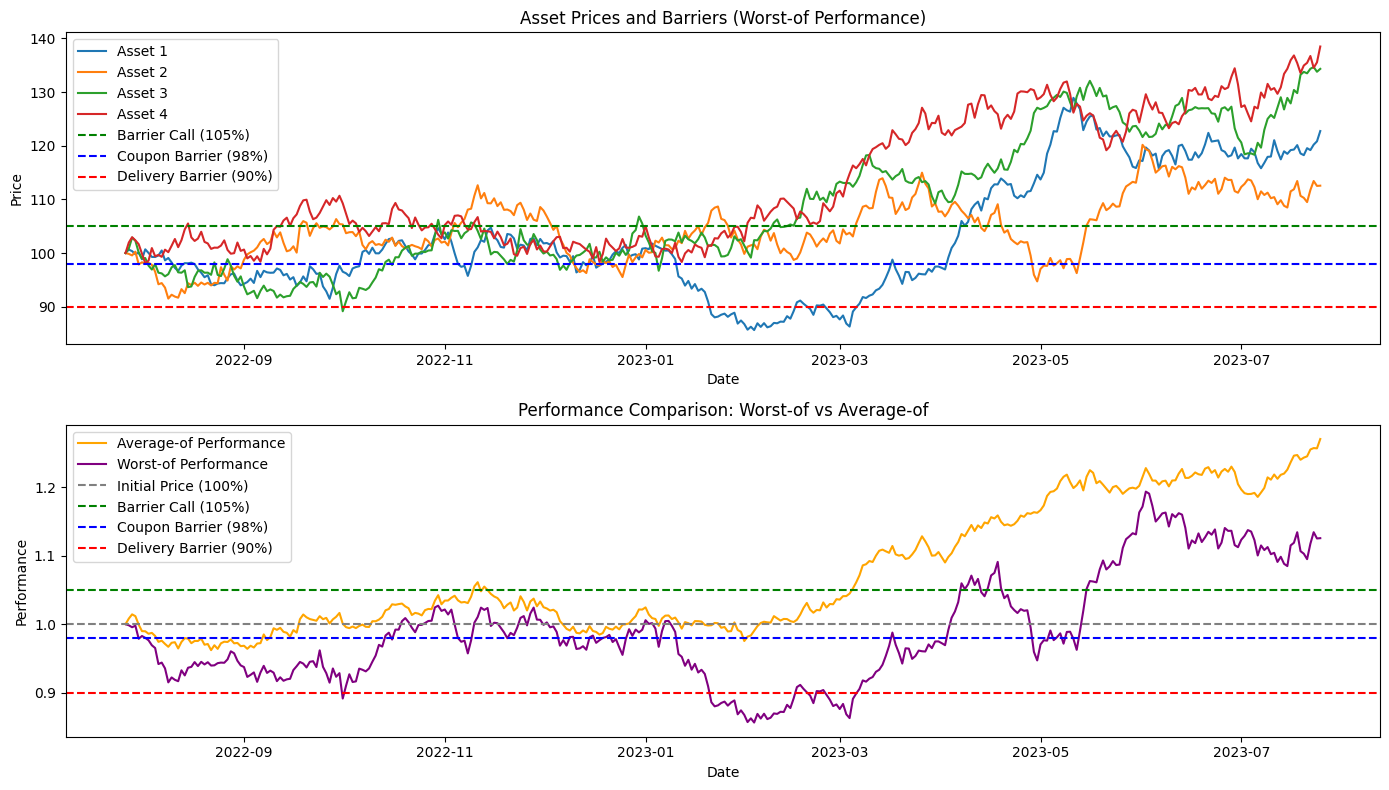

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


initial_investment = 5_000_000
coupon_rate = 0.20 / 4  
barrier_call = 1.05 
coupon_barrier = 0.98  
delivery_barrier = 0.90 

launch_date = "2022-07-27"
maturity_date = "2023-07-25"
observation_dates = ["2022-10-25", "2023-01-25", "2023-04-25", maturity_date]


dates = pd.date_range(launch_date, maturity_date, freq="D")
np.random.seed(42)  
n_assets = 4
initial_prices = np.array([100] * n_assets)  


def simulate_gbm(S0, mu, sigma, n_days, n_assets):
    dt = 1 / 252
    prices = np.zeros((n_days, n_assets))
    prices[0] = S0
    for t in range(1, n_days):
        Z = np.random.normal(0, 1, n_assets)
        prices[t] = prices[t - 1] * np.exp((mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z)
    return prices


mu = 0.05  
sigma = 0.2
prices = simulate_gbm(initial_prices, mu, sigma, len(dates), n_assets)
prices_df = pd.DataFrame(prices, index=dates, columns=[f"Asset {i+1}" for i in range(n_assets)])


def performance_analysis(prices_df, initial_prices, method="worst-of"):
    results = []
    cumulative_coupon = 0.0

    if method == "average-of":
        performance = prices_df.mean(axis=1) / initial_prices.mean()
    else:  # worst-of
        performance = prices_df.min(axis=1) / initial_prices.min()

    for obs_date in observation_dates:
        perf = performance.loc[obs_date]

        if perf >= barrier_call:
            coupon = initial_investment * coupon_rate
            results.append((obs_date, "Early Redemption", coupon))
            cumulative_coupon += coupon
            break
        elif perf >= coupon_barrier:
            coupon = initial_investment * coupon_rate
            results.append((obs_date, "Coupon Paid", coupon))
            cumulative_coupon += coupon
        else:
            results.append((obs_date, "No Coupon", 0))
    else:
        final_perf = performance.loc[maturity_date]
        if final_perf >= delivery_barrier:
            results.append((maturity_date, "Maturity: Nominal Returned", initial_investment))
        else:
            delivery_value = final_perf * initial_investment
            results.append((maturity_date, "Maturity: Delivery Value", delivery_value))

    return pd.DataFrame(results, columns=["Date", "Action", "Amount"])

results_worst_df = performance_analysis(prices_df, initial_prices, method="worst-of")
results_avg_df = performance_analysis(prices_df, initial_prices, method="average-of")


def plot_results(prices_df, initial_prices, barrier_call, coupon_barrier, delivery_barrier):
    plt.figure(figsize=(14, 8))


    plt.subplot(2, 1, 1)
    for col in prices_df.columns:
        plt.plot(prices_df.index, prices_df[col], label=col)
    plt.axhline(y=initial_prices.min() * barrier_call, color="green", linestyle="--", label="Barrier Call (105%)")
    plt.axhline(y=initial_prices.min() * coupon_barrier, color="blue", linestyle="--", label="Coupon Barrier (98%)")
    plt.axhline(y=initial_prices.min() * delivery_barrier, color="red", linestyle="--", label="Delivery Barrier (90%)")
    plt.title("Asset Prices and Barriers (Worst-of Performance)")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()

 
    plt.subplot(2, 1, 2)
    avg_perf = prices_df.mean(axis=1) / initial_prices.mean()
    worst_perf = prices_df.min(axis=1) / initial_prices.min()
    plt.plot(avg_perf.index, avg_perf, label="Average-of Performance", color="orange")
    plt.plot(worst_perf.index, worst_perf, label="Worst-of Performance", color="purple")
    plt.axhline(y=1, color="gray", linestyle="--", label="Initial Price (100%)")
    plt.axhline(y=barrier_call, color="green", linestyle="--", label="Barrier Call (105%)")
    plt.axhline(y=coupon_barrier, color="blue", linestyle="--", label="Coupon Barrier (98%)")
    plt.axhline(y=delivery_barrier, color="red", linestyle="--", label="Delivery Barrier (90%)")
    plt.title("Performance Comparison: Worst-of vs Average-of")
    plt.xlabel("Date")
    plt.ylabel("Performance")
    plt.legend()

    plt.tight_layout()
    plt.show()


plot_results(prices_df, initial_prices, barrier_call, coupon_barrier, delivery_barrier)



* Результаты:
    - Продукт был досрочно погашен на первой дате наблюдения (25-10-2022) в обоих сценариях.
    - Средневзвешенная методика (average-of) демонстрирует более плавную динамику.



    - Моделирование показало, как различные уровни барьеров влияют на действия (досрочное погашение, купонные выплаты и поставка).
     Worst-of более чувствителен к просадкам отдельных активов, тогда как Average-of сглаживает динамику.
    

    - Графики показывают динамику цен активов, производительность (Worst-of, Average-of) и уровни барьеров.
    - Показаны важные даты: купонные и финальная дата погашения.


In [16]:
results_worst_df

,Date,Action,Amount
0,2022-10-25,Coupon Paid,250000.0
1,2023-01-25,No Coupon,0.0
2,2023-04-25,Coupon Paid,250000.0
3,2023-07-25,Early Redemption,250000.0


In [17]:
results_avg_df

,Date,Action,Amount
0,2022-10-25,Coupon Paid,250000.0
1,2023-01-25,Coupon Paid,250000.0
2,2023-04-25,Early Redemption,250000.0


# Основные выводы:
* В случае worst-of производительность одного из активов (самый слабый) не всегда позволяла выплатить купон в каждом наблюдательном периоде.
* В случае average-of средняя производительность активов была более стабильной и обеспечила выплату купонов в каждом квартале, а также привела к досрочному погашению на 2023-04-25.
* Это также демонстрирует, как различаются методы учета производительности для такого продукта:

* Worst-of может привести к более редким выплатам, так как рассчитывается минимальная производительность среди всех активов.
* Average-of склонен к более частым выплатам, поскольку учитывает среднюю производительность.